# 0 Vorbereitung

### Laden der Pakete

In [1]:
import pandas as pd
import os
import gc
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

### Funktionen zur Evaluation definieren

In [2]:
#Diese Funktionen helfen später die Modellergebnisse zu evaluieren
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#Berechnet AUC & Accuracy für Test & Train
def print_scoring_results(name_of_model, y_test_proba, y_train_proba):
    acc_test = accuracy_score(y_test, np.ravel(np.where(y_test_proba>=0.5, 1, 0)))
    auc_test = roc_auc_score(y_test, y_test_proba)

    acc_train = accuracy_score(y_train, np.ravel(np.where(y_train_proba>=0.5, 1, 0)))
    auc_train = roc_auc_score(y_train, y_train_proba)

    print(f"{name_of_model} test accuracy ist {'{:,.2%}'.format(acc_test)}")
    print(f"{name_of_model} test AUC ist {'{:,.2%}'.format(auc_test)}")
    print(f"{name_of_model} train accuracy ist {'{:,.2%}'.format(acc_train)}")
    print(f"{name_of_model} train AUC ist {'{:,.2%}'.format(auc_train)}")

    
#Berechnet Accuracy im Test Datensatz für verschiedene Cutoff Werte
def tp_cutoffs(y_test_proba):
    
    result_df = pd.DataFrame({"threshold": [float(i)/100 for i in range(5, 55, 5)] , "TP":0, "FP":0, "Diff":0})
    
    for index, row in result_df.iterrows():
        result_df.iloc[index, 1] = confusion_matrix(y_test, np.ravel(np.where(y_test_proba>row["threshold"],1,0)), normalize="true")[1,1]
        result_df.iloc[index, 2] = confusion_matrix(y_test, np.ravel(np.where(y_test_proba>row["threshold"],1,0)), normalize="true")[0,1]
        result_df.iloc[index, 3] = result_df.iloc[index, 1]-result_df.iloc[index, 2]
    
    Best_tradeoff_row = pd.DataFrame(result_df[result_df["Diff"]==np.max(result_df["Diff"])])
    
    Best_tradeoff_string = f"Der beste Tradeoff zwischen TP & FP wird bei einem Threshold von {Best_tradeoff_row.threshold.values[0]} mit TP: {'{:,.2%}'.format(Best_tradeoff_row.TP.values[0]) } & FP: {'{:,.2%}'.format(Best_tradeoff_row.FP.values[0]) } erzielt."
    
    
    return result_df, Best_tradeoff_string

### Datensätze & Pipelines laden

In [3]:
X_train = pd.read_parquet("/kaggle/input/axa-challenge-final/X_train.parquet")
X_test = pd.read_parquet("/kaggle/input/axa-challenge-final/X_test.parquet")

y_train = pd.read_parquet("/kaggle/input/axa-challenge-final/y_train.parquet")
y_test = pd.read_parquet("/kaggle/input/axa-challenge-final/y_test.parquet")

### Datentypen anpassen, da enige Formate beim Speichern als Parquet verloren gingen

In [4]:
X_train["start station id"] = X_train["start station id"].astype("object")
X_train["end station id"] = X_train["end station id"].astype("object")
X_train["month"] = X_train["month"].astype("object")
X_train["time_hours"] = X_train["time_hours"].astype("object")

X_train["same_start_end"] = X_train["time_hours"].astype("int8")


X_test["start station id"] = X_test["start station id"].astype("object")
X_test["end station id"] = X_test["end station id"].astype("object")
X_test["month"] = X_test["month"].astype("object")
X_test["time_hours"] = X_test["time_hours"].astype("object")

X_test["same_start_end"] = X_test["time_hours"].astype("int8")

### Laden der Pipelines und Abhängigkeit (Feature Engine)

In [5]:
%%capture
! pip install feature_engine

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import FunctionTransformer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import MeanEncoder
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [7]:
import joblib

def log_trans(x):
    return np.log(x+0.01)

preprocessor_benchmark =joblib.load("/kaggle/input/axa-challenge-final/preprocessor_benchmark.joblib")
preprocessor_1 =joblib.load("/kaggle/input/axa-challenge-final/preprocessor_final_1.joblib")
preprocessor_2 =joblib.load("/kaggle/input/axa-challenge-final/preprocessor_final_2.joblib")

### Datensatz verkleinern, da es mit dem vollen Trainings Datensatz zu Memory Problemen kommt

In [8]:
train_tmp = pd.concat([X_train, y_train], axis=1).sample(frac=0.5, random_state=1)

In [9]:
X_train = train_tmp.drop("usertype", axis=1)
y_train = train_tmp["usertype"]

In [10]:
del train_tmp
gc.collect()

63

In [11]:
#Definition der Namens Pipelines
name_list_pipeline1 = ["gender_1", "gender_2"] + ["age"+ str(i) for i in range(1, 10)] + \
["tripduration_wind_log", "distance_travelled_m_wind_log"] + ["start_station_mean_encoded", "end_station_mean_encoded"] + \
["month" + str(i) for i in range(1, 12)] + ["weekday"+ str(i) for i in range(1, 7)] + ["time_hours"+ str(i) for i in range(1, 24)] + \
["same_start_end"] + ["is_holiday"]

name_list_pipeline2 = ["gender_1", "gender_2"] + ["age"+ str(i) for i in range(1, 10)] + \
["tripduration_wind_log", "distance_travelled_m_wind_log"] + ["start_station_mean_encoded", "end_station_mean_encoded"] + \
["month_mean_encoded"] + ["weekday_mean_encoded"] + ["time_hours_mean_encoded"] + ["same_start_end"] + ["is_holiday"]

# 7 Modell Vergleiche

## 7.1 Benchmark (Elastic Net nur mit Zeit Variablen)

### 7.1.0 Referenz: immer die häufigste Klasse vorhersagen

In [12]:
print_scoring_results("Referenz", np.full(len(y_test), 0) , np.full(len(y_train), 0) )

Referenz test accuracy ist 88.97%
Referenz test AUC ist 50.00%
Referenz train accuracy ist 88.99%
Referenz train AUC ist 50.00%


### 7.1.1 Fit Model

Als Benchmark wird ein Modell gerechnet, welches nur die Zeitvariablen enthält

In [13]:
#Variablen mittelwert-bereinigen
Scaler = StandardScaler(with_mean=True)

#Hyperparameter wurden durch Tuning ermittelt
Pipeline_benchmark = Pipeline([("preprocessor_pipeline", preprocessor_benchmark), 
                               ("scaling", StandardScaler(with_mean=True) ),
                            ('lasso', LogisticRegression(random_state=1, penalty="elasticnet", solver="saga", C=0.018298277344191805, l1_ratio=0.7501443149449675))])

Pipeline_benchmark.fit(X_train, y_train)

#Train & Test Predictions
y_test_proba_benchmark = Pipeline_benchmark.predict_proba(X_test)[:,1]
y_train_proba_benchmark = Pipeline_benchmark.predict_proba(X_train)[:,1]

### 7.1.2 Model Ergebnisse

In [14]:
print_scoring_results("Benchmark", y_test_proba_benchmark, y_train_proba_benchmark)

Benchmark test accuracy ist 88.97%
Benchmark test AUC ist 71.86%
Benchmark train accuracy ist 88.99%
Benchmark train AUC ist 71.92%


In [15]:
tp_cutoffs_df, tp_cutoffs_string = tp_cutoffs(y_test_proba_benchmark)

print(tp_cutoffs_df)
print(tp_cutoffs_string)

   threshold        TP        FP      Diff
0       0.05  0.935116  0.712592  0.222524
1       0.10  0.740779  0.418936  0.321843
2       0.15  0.510868  0.222142  0.288726
3       0.20  0.284092  0.102642  0.181450
4       0.25  0.190489  0.063327  0.127162
5       0.30  0.096432  0.030974  0.065458
6       0.35  0.003328  0.000860  0.002469
7       0.40  0.000000  0.000000  0.000000
8       0.45  0.000000  0.000000  0.000000
9       0.50  0.000000  0.000000  0.000000
Der beste Tradeoff zwischen TP & FP wird bei einem Threshold von 0.1 mit TP: 74.08% & FP: 41.89% erzielt.


## 7.2 Elastic Net Classifier

### 7.2.1 Fit Model

In [16]:
#Variablen mittelwert-bereinigen
Scaler = StandardScaler(with_mean=True)

#Hyperparameter wurden durch Tuning ermittelt
Pipeline_elastic = Pipeline([("preprocessor_pipeline", preprocessor_1), 
                               ("scaling", StandardScaler(with_mean=True) ),
                            ('elastic', LogisticRegression(random_state=1, penalty="elasticnet", solver="saga", C=0.9034119152878834, l1_ratio= 0.13747470414623753))])

Pipeline_elastic.fit(X_train, y_train)

#Train & Test Predictions
y_test_proba_elastic = Pipeline_elastic.predict_proba(X_test)[:,1]
y_train_proba_elastic = Pipeline_elastic.predict_proba(X_train)[:,1]

### 7.2.2 Model Ergebnisse

In [17]:
print_scoring_results("Elastic", y_test_proba_elastic, y_train_proba_elastic)

Elastic test accuracy ist 94.60%
Elastic test AUC ist 93.22%
Elastic train accuracy ist 94.60%
Elastic train AUC ist 93.22%


In [18]:
tp_cutoffs_df, tp_cutoffs_string = tp_cutoffs(y_test_proba_elastic)

print(tp_cutoffs_df)
print(tp_cutoffs_string)

   threshold        TP        FP      Diff
0       0.05  0.898928  0.228035  0.670893
1       0.10  0.824645  0.110037  0.714609
2       0.15  0.775514  0.068027  0.707487
3       0.20  0.740445  0.047682  0.692763
4       0.25  0.714054  0.036075  0.677979
5       0.30  0.693050  0.028717  0.664333
6       0.35  0.675264  0.023674  0.651590
7       0.40  0.658774  0.019953  0.638821
8       0.45  0.643376  0.017050  0.626326
9       0.50  0.628178  0.014562  0.613616
Der beste Tradeoff zwischen TP & FP wird bei einem Threshold von 0.1 mit TP: 82.46% & FP: 11.00% erzielt.


### 7.2.3 Feature Importance

In [19]:
elastic_model_coefs = Pipeline_elastic['elastic'].coef_[0]

In [20]:
coef_df = pd.DataFrame({"coef":elastic_model_coefs, "coef_abs":np.abs(elastic_model_coefs)}, index=name_list_pipeline1)

coef_df["positive"] = np.where(coef_df["coef"]>=0, True, False)
coef_df.sort_values(by="coef_abs", ascending=False, inplace=True)


<AxesSubplot:>

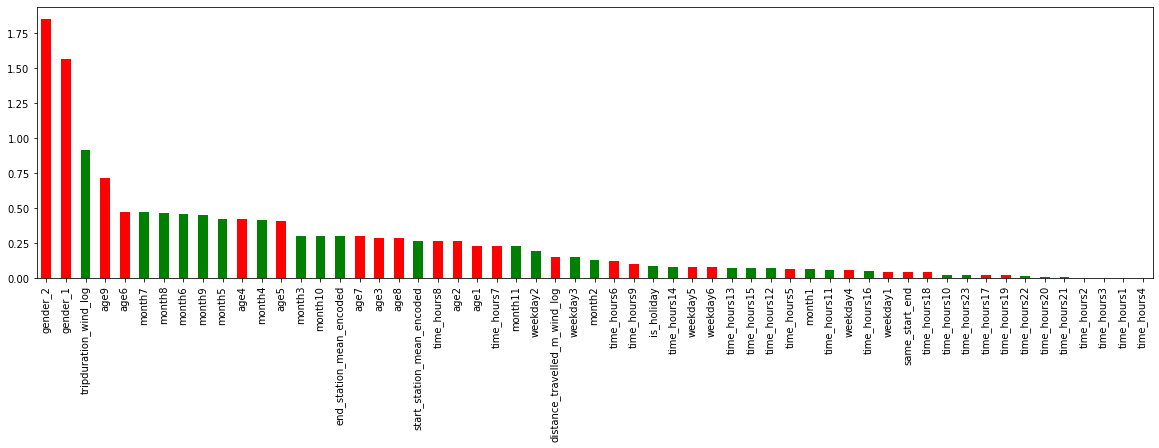

In [21]:
plt.rcParams["figure.figsize"] = (20,5)
coef_df["coef_abs"].plot.bar(color=coef_df.positive.map({True: 'g', False: 'r'}))

Erkenntnisse:
* Das Vorhandensein von gender Informationen hat den größten Einfluss auf den Customer/Subscriber Status. Falls die Information vorhanden ist, klassifiziert da Model Kunden eher als Subscriber
* Je länger der Trip dauert, desto eher ist der Kunde ein Customer
* Auch die Sommermonate scheinen einen großen Einfluss darauf zu haben ob ein Kunde als Customer/Subscriber klassifiziert wird
* Die Altersklassen haben einen deutlich negativen Einfluss, wobei höhere Altersklassen eher als Subscriber klassifiert werden
* Die mean-encoded start & end stations haben einen positiven Einfluss. Das muss per Definition zu sein. Es ist aber spannend zu sehen, dass der Einfluss im Mittelfeld rangiert, d.h. es ist relevant wo die Trips starten und enden
* Die Uhrzeiten haben einen eher geringen Einfluss mit Ausnahme von 7/8 Uhr wo das Model dazu tendiert Subscriber zu klassifizieren

 ## 7.3 Neural Network Classifier

### 7.3.1 Predict Model --> gerechnetes Model wird geladen

In [22]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model('/kaggle/input/axa-challenge-nn-smaller/Final_NN.h5')
X_train_transformed = preprocessor_1.fit_transform(X_train, y_train)
X_test_transformed = preprocessor_1.transform(X_test)

#Train & Test Predictions
y_train_proba_nn = loaded_model.predict(X_train_transformed, workers=8, use_multiprocessing=True, verbose=1)
y_test_proba_nn = loaded_model.predict(X_test_transformed, workers=8, use_multiprocessing=True, verbose=1)

2022-12-11 19:02:32.438627: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-11 19:03:14.774543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


164516/164516 [==============================] - 531s 3ms/step


### 7.3.2 Model Ergebnisse

In [23]:
print_scoring_results("Neural Network", y_test_proba_nn, y_train_proba_nn)

Neural Network test accuracy ist 95.09%
Neural Network test AUC ist 94.60%
Neural Network train accuracy ist 95.12%
Neural Network train AUC ist 94.74%


In [24]:
tp_cutoffs_df, tp_cutoffs_string = tp_cutoffs(y_test_proba_nn)

print(tp_cutoffs_df)
print(tp_cutoffs_string)

   threshold        TP        FP      Diff
0       0.05  0.928896  0.247050  0.681846
1       0.10  0.857390  0.109729  0.747661
2       0.15  0.812295  0.068350  0.743945
3       0.20  0.773460  0.045621  0.727839
4       0.25  0.742566  0.033006  0.709560
5       0.30  0.717123  0.025140  0.691983
6       0.35  0.694814  0.019716  0.675098
7       0.40  0.674731  0.015727  0.659005
8       0.45  0.655603  0.012622  0.642980
9       0.50  0.637651  0.010292  0.627359
Der beste Tradeoff zwischen TP & FP wird bei einem Threshold von 0.1 mit TP: 85.74% & FP: 10.97% erzielt.


## 7.4 LGBM Classifier

### 7.4.1 Fit Model

In [25]:
from lightgbm import LGBMClassifier

Pipeline_lgbm = Pipeline([("preprocessor_pipeline", preprocessor_2), 
                            ('lgbm', LGBMClassifier(learning_rate= 0.0266292630148277, max_depth=9, min_child_samples= 56, n_estimators= 527, num_leaves= 83, reg_alpha= 0.4, n_jobs=4, importance_type="gain") )])


Pipeline_lgbm.fit(X_train, y_train)

y_test_proba_lgbm = Pipeline_lgbm.predict_proba(X_test)[:,1]
y_train_proba_lgbm = Pipeline_lgbm.predict_proba(X_train)[:,1]

### 7.4.2 Model Ergebnisse

In [26]:
print_scoring_results("Light GBM", y_test_proba_lgbm, y_train_proba_lgbm)

Light GBM test accuracy ist 95.16%
Light GBM test AUC ist 94.72%
Light GBM train accuracy ist 95.19%
Light GBM train AUC ist 94.85%


In [27]:
tp_cutoffs_df, tp_cutoffs_string = tp_cutoffs(y_test_proba_lgbm)

print(tp_cutoffs_df)
print(tp_cutoffs_string)

   threshold        TP        FP      Diff
0       0.05  0.910197  0.192548  0.717649
1       0.10  0.850281  0.098648  0.751632
2       0.15  0.809151  0.063632  0.745519
3       0.20  0.776936  0.045124  0.731812
4       0.25  0.750166  0.033759  0.716407
5       0.30  0.726831  0.026114  0.700717
6       0.35  0.706235  0.020796  0.685439
7       0.40  0.687695  0.016844  0.670851
8       0.45  0.670319  0.013830  0.656489
9       0.50  0.653509  0.011450  0.642059
Der beste Tradeoff zwischen TP & FP wird bei einem Threshold von 0.1 mit TP: 85.03% & FP: 9.86% erzielt.


### 7.4.3 Feature Importance

<AxesSubplot:>

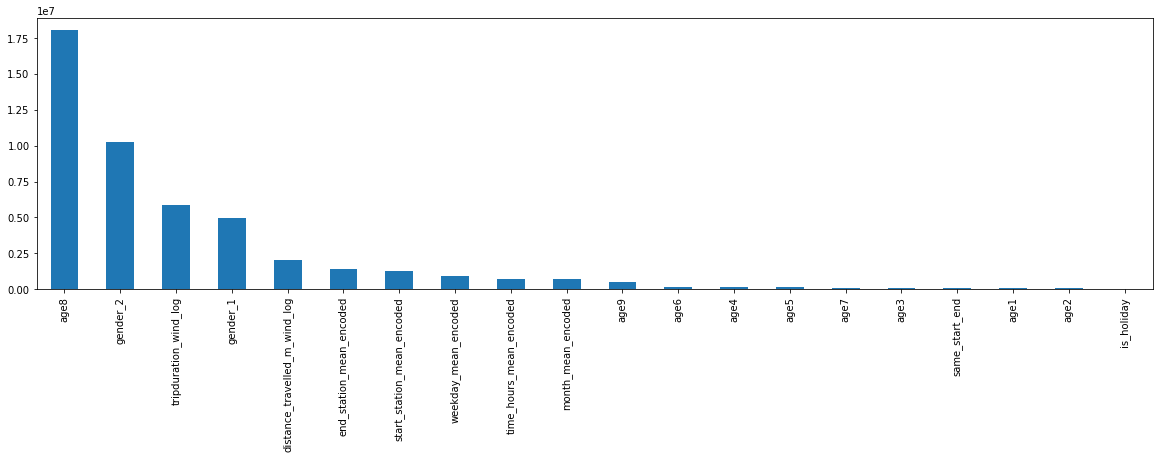

In [28]:
lgbm_fi = pd.DataFrame({"fi": Pipeline_lgbm["lgbm"].feature_importances_}, index=name_list_pipeline2)

lgbm_fi.sort_values(by="fi", ascending=False, inplace=True)

plt.rcParams["figure.figsize"] = (20,5)
lgbm_fi["fi"].plot.bar()

Erkenntnisse:
* Die Bäume des Modells profitieren am stärksten davon die Altersklasse 8 (für die wir in der EDA gesehen haben, dass der Anteil der Dubscriber hoch ist) für Splits zu nutzen
* Daneben sind wie im Elastic Model auch das Vorhandensein von gender Informationen sowie die tripduration wichtig
* Im Gegensatz zum Elastic Model scheint die Variable distance_travelled wichtiger zu sein
* Die Informationen zur start und end station sind wie im elastic Model im Mittelfeld
* Das gleiche trifft auf die Zeitvariablen zu

# 8 Einsatzgebiete oder UseCases 

## 8.1 Conversion Customers zu Subscribern

**Annahme:** 

Subscriber sind für Citibike profitabler als Customer


**Idee:**

Durch das Modell können wir Kunden identifizieren, die einen geringe vorhergesagte Wahrscheinlichkeit für customer haben. Solche Kunden weisen durch die Strecken die sie fahren eine hohe Wahrscheinlichkeit auf subscriber zu werden, haben sich aber noch nicht dafür entschieden. Diesen Kunden kann damit ein personalisiertes Angebot ausgespielt werden, z.B. in Form eines Rabattes auf die jährliche Mitgliedschaft

In [29]:
target_customer= pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True) ,pd.DataFrame({"score": y_test_proba_lgbm})], axis=1)

target_customer = target_customer[target_customer["usertype"]==1].sort_values(by="score")

target_customer.head(20)


,tripduration,start station id,end station id,gender,age,month,weekday,time_hours,distance_travelled_m,same_start_end,is_holiday,usertype,score
3668823,136,441.0,3459.0,male,56,2,Monday,9,389.879059,9,0,1,0.000564
1614880,175,454.0,3459.0,male,56,2,Thursday,17,716.953369,17,0,1,0.000582
5171752,259,3290.0,3286.0,male,63,12,Monday,15,979.001221,15,0,1,0.000607
2798817,174,454.0,3459.0,male,56,2,Monday,19,716.953369,19,0,1,0.000608
3338105,152,435.0,466.0,male,55,10,Tuesday,10,546.945007,10,0,1,0.000649
5107730,129,3263.0,483.0,male,57,8,Thursday,14,508.003571,14,0,1,0.000651
3901165,218,537.0,402.0,female,55,2,Sunday,8,616.084595,8,0,1,0.000654
5170212,169,455.0,454.0,male,56,2,Sunday,0,851.402527,0,0,1,0.000698
2901883,1086,519.0,377.0,male,59,3,Thursday,8,6378.651855,8,0,1,0.000699
2953215,631,237.0,284.0,male,58,2,Thursday,7,2718.198975,7,0,1,0.000703


In [30]:
del target_customer
gc.collect()

102

## 8.2 Nutzung starker Modelltreiber

**Annahme:** 

Subscriber sind für Citibike profitabler als Customer


**Idee:**

Durch die Feature Importance sehen wir Faktoren, die zu einer erhöhten Nutzung als 
Customer bzw. Subscriber führen. Diese Faktoren kann Citibike strategisch nutzen um das Geschäftsmodell zu verbessern

### 8.2.1 Änderung des Tarifs von Citibike um lange Trips unattraktiver zu machen 

<AxesSubplot:>

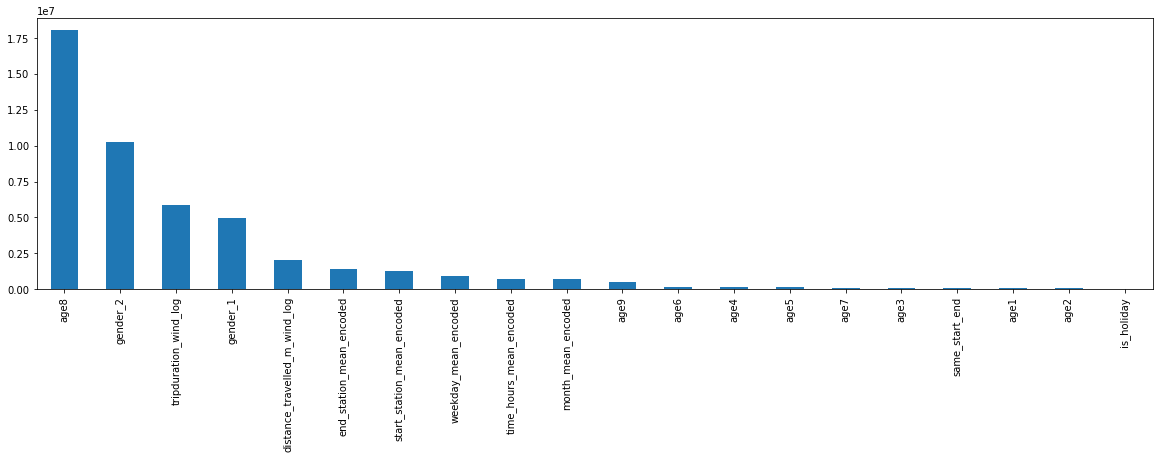

In [31]:
plt.rcParams["figure.figsize"] = (20,5)
lgbm_fi["fi"].plot.bar()

<AxesSubplot:>

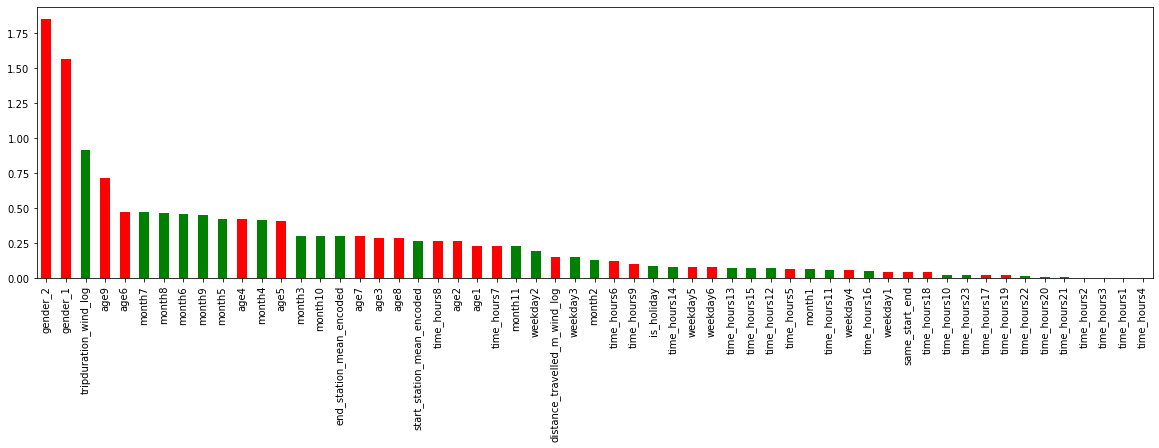

In [32]:
plt.rcParams["figure.figsize"] = (20,5)
coef_df["coef_abs"].plot.bar(color=coef_df.positive.map({True: 'g', False: 'r'}))

Customer scheinen die Citibikes länger zu nutzen als Subscriber (wahrscheinlich weil man mit dem 24h/3 Tage Pass unbegrenzt fahren kann). Der Tarif könnte geändert werden, so dass keine unbegrenzten Fahrten mehr möglich sind sondern nur noch z.B. 60 Minuten. Im Subscriber Modell bleiben unbegrenzte Fahrten aber möglich

--> Für Nutzer die das Citibike für lange Fahrten brauchen wird das Subscriber Modell attraktiver

### 8.2.2 Kooperation mit Arbeitgebern und Tourismusverbänden für die Nutzung des Citibikes

Aus den Modeltreibern und der EDA sehen wir, dass Subscriber besonders häufig zur Rushhour fahren und customer das Citibike vermehrt in den Sommermonaten nutzen. Vermutlich wird letzteres auch durch Touristen beeinflusst

* Citibike könnte versuchen Arbeitgeber für eine Kooperation zu gewinnen damit Arbeitgeber ihren Arbeitnehmern ein reduziertes Subscriber Modell anbieten können
* Citibike könnte mit Tourismusverbänden kooperieren um Citibike Tagespässe in verschiedene Tourismusboundles zu integrieren und so mehr Kunden erreichen

# 9 CitiBike Kooperationsmöglichkeiten mit einer Versicherung 

## 9.1 Versicherungsprämien werden abhängig von Subscribern & Customer gezahlt

Wir haben gesehen, dass Customer ihr Citibike länger nutzen und weiter damit fahren. Dadurch steigt auch die Wahrscheinlichkeit eines Unfalls (Haftpflicht) bzw. Diebstahl/Vandalismus etc. Daneben sind Subscriber durch die regelmäßigere Nutzung wahrscheinlich die geübteren Fahrradfahrer

--> Die Versicherung könnte dann einen reduzierten Versicherungs-Tarif für Subscriber anbieten. Dadurch kann die Versicherung ihr Risiko besser steuern und Citibike kann den Subscribern günstigere Abo-Preise anbieten

## 9.2 Heranspielen von Schadensdaten an den Datensatz um den Einfluss verschiedener Faktoren besser zu ermitteln

Der Datensatz bzw. ein  regelmäßiger Datenaustausch wäre für die Versicherung vorteilhaft, da sie alle im aktuellen Modell genutzte Variablen nutzen könnte um Risikofaktoren zu berechnen. Faktoren könnten z.B. sein:

* Welche Stationen sind besonders stark von Vandalismus betroffen?
* Zwischen welchen Strecken steigt das Risiko eines Unfalls?
* Welche Altersklasse haben das höchste Unfallrisiko?
* Zu welchen Uhrzeiten ist das Risiko eines Unfalls am höchsten?
* Wie beeinflusst Subscriber/Customer Status das Unfallrisiko?

## 9.3 Zusatzversicherungen für Subscriber

Wir haben gesehen, dass Subscriber ein anderes Nutzungsprofil haben. Darauf basierend können Zusatzversicherungen entweder im Subscriber Modell angeboten werden um das Modell attraktiver zu machen oder als bezahlte Zusatzleistung. Möglichkeiten wären z.B.

* Mobilitätsgarantie: sollte kein Fahrrad an der Station zur Verfügung stehen, wird eine Fahrt mit Taxi/Uber bezahlt. Wie oft das passiert, könnte man wahrscheinlich aus dem Datensatz berechnen
* Verlust & Beschädigungs Versicherung: Verluste und Beschädigungen die infolge einer Fahrradfahrt passieren, werden beglichen. Z.B. wichtig für Pendler die mit Laptop unterwegs sind

Andersherum funktioniert das natürlich auch, z.B. für Customer:
* Optional buchbares Rundum Sorglos Paket als eine Unfallversicherung die alle Krankheiten versichert die infolge eines Unfalls mit dem Citibike auftreten --> attraktiv für weniger geübte Radfahrer die das Citibike nur selten nutzen


